In [1]:
pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import html
from datasets import Dataset

# Torch ML libraries
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import nltk
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
nltk.download('punkt')
import re

# Misc.
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available - Using GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available - Using CPU")
    device = torch.device('cpu')

GPU is available - Using GPU


In [4]:
pd.set_option('display.max_colwidth', 1000)

def display_feature_list(features, feature_type):

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

def describe_df(df):

    global categorical_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')

    display_feature_list(categorical_features, 'Categorical')

    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [5]:
df = pd.read_csv('news_sentiment_analysis.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3500 non-null   object
 1   Author        2512 non-null   object
 2   Title         3500 non-null   object
 3   Description   3500 non-null   object
 4   URL           3500 non-null   object
 5   Published At  3500 non-null   object
 6   Sentiment     3500 non-null   object
 7   Type          3500 non-null   object
dtypes: object(8)
memory usage: 218.9+ KB


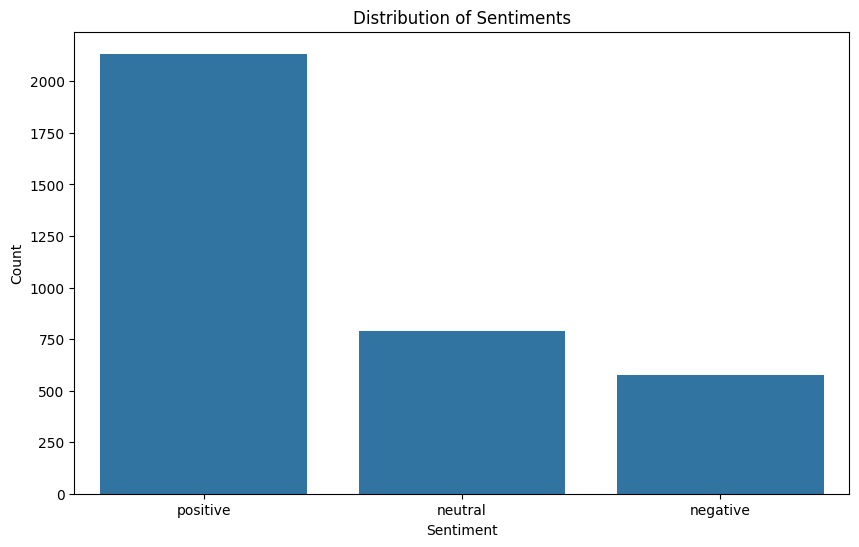

In [7]:
#Distribution of sentiments
plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment',data=df)
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel('Count')
plt.show()

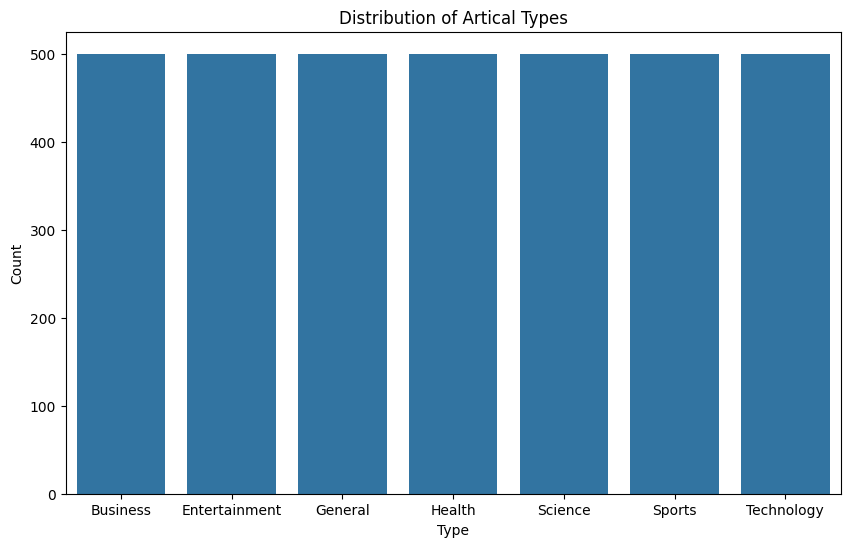

In [8]:
# Distribution of artical types
plt.figure(figsize=(10,6))
sns.countplot(x='Type', data=df)
plt.title('Distribution of Artical Types')
plt.xlabel("Type")
plt.ylabel('Count')
plt.show()

In [9]:
# remove unwanted columns
df = df.drop(['Source','Author','Title','URL','Published At'],axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3500 non-null   object
 1   Sentiment    3500 non-null   object
 2   Type         3500 non-null   object
dtypes: object(3)
memory usage: 82.2+ KB


In [11]:
describe_df(df)


DataFrame shape: (3500, 3)

3,500 samples

Missing Data: 
Description    0
Sentiment      0
Type           0
dtype: int64

Duplicates: 1031

Categorical Features: 
Description, Sentiment, Type

DataFrame Head: 



,Description,Sentiment,Type
0,"ST. GEORGE — Kaitlyn Larson, a first-year teacher at Pine View High School, recently received the Best in State award for a business leadership course. Larson’s students in grades 10-12 had the highest passing rate on the YouScience exam during the spring and fall semesters of 2023. The YouScience exam is similar to final exams [&#8230;]",positive,Business
1,"Harare, Zimbabwe – Local businesses are grappling with a severe liquidity crunch, which is limiting [...]",neutral,Business
2,"(marketscreener.com) Billionaire Elon Musk has donated to a super pac working to elect former U.S. President Donald Trump, Bloomberg reported on Friday, citing sources. The report did not indicate how much Musk donated but added it was ""a sizable amount"" given to a group called America PAC. https://www.marketscreener.com/business-leaders/Elon-Musk-1364/news/Musk-donates-to-super-pac-working-to-elect-Trump-Bloomberg-reports--47374715/?utm_medium=RSS&utm_content=20240712",positive,Business
3,"(marketscreener.com) A U.S. trade regulator on Fridayannounced a suite of actions taking aim at ""unfair and deceptivepractices"" it said are illegally imposed on U.S. franchisees bytheir brand owners, such as requiring new fees not outlined infranchise contracts, or using contract provisions to discouragefranchisees from speaking with regulators. The...https://www.marketscreener.com/quote/stock/MCDONALD-S-CORPORATION-4833/news/US-FTC-issues-warning-to-franchisors-over-unfair-business-practices-47374706/?utm_medium=RSS&utm_content=20240712",negative,Business
4,"4.5 million households in the U.S. have solar panels on their homes. Most of those customers are happy with it - their electricity bills have just about disappeared, and it's great for the planet. But thousands and thousands of people are really disappointed with what they've been sold. Their panels are more expensive than they should be, and they say it is hard to get someone to come fix them when they break. It turns out this sometimes crummy customer experience is no accident. It ties back to how big, national solar companies built their businesses in the first place. To entice people to...",positive,Business



DataFrame Tail: 



,Description,Sentiment,Type
3495,"QRG Capital Management Inc. increased its stake in shares of Arrow Electronics, Inc. (NYSE:ARW &#8211; Free Report) by 1.7% in the 1st quarter, according to its most recent 13F filing with the Securities and Exchange Commission (SEC). The fund owned 6,223 shares of the technology company&#8217;s stock after purchasing an additional 107 shares during the [&#8230;]",positive,Technology
3496,"QRG Capital Management Inc. bought a new position in NICE Ltd. (NASDAQ:NICE &#8211; Free Report) in the first quarter, according to its most recent disclosure with the Securities and Exchange Commission. The institutional investor bought 3,120 shares of the technology company&#8217;s stock, valued at approximately $813,000. Other institutional investors and hedge funds have also recently [&#8230;]",positive,Technology
3497,"QRG Capital Management Inc. boosted its stake in Akamai Technologies, Inc. (NASDAQ:AKAM &#8211; Free Report) by 27.0% during the first quarter, according to the company in its most recent filing with the SEC. The fund owned 7,878 shares of the technology infrastructure company&#8217;s stock after buying an additional 1,677 shares during the period. QRG Capital [&#8230;]",positive,Technology
3498,"WESTFORD, Mass., July 18, 2024 /PRNewswire/ -- According to SkyQuest, the global Biotechnology Market size was valued at USD 1.21 Trillion in 2022 and is poised to grow from USD 1.38 Trillion in 2...",neutral,Technology
3499,"QRG Capital Management Inc. reduced its holdings in shares of Seagate Technology Holdings plc (NASDAQ:STX &#8211; Free Report) by 13.9% in the first quarter, according to its most recent filing with the SEC. The fund owned 10,324 shares of the data storage provider&#8217;s stock after selling 1,665 shares during the period. QRG Capital Management Inc.&#8217;s [&#8230;]",positive,Technology


In [12]:
# Function to clean text
def remove_unwanted_text(text):
    return re.sub(r"\[.*?\]|\(.*?\)", "", text)

#function to decode html
def decode_html(text):
    return html.unescape(text)

# Function to remove URLs using regex
def remove_links(text):
    return re.sub(r'http\S+', '', text)

df['Description'] = df['Description'].apply(remove_unwanted_text)
df['Description'] = df['Description'].apply(decode_html)
df['Description'] = df['Description'].apply(remove_links)

In [13]:
df.head()

,Description,Sentiment,Type
0,"ST. GEORGE — Kaitlyn Larson, a first-year teacher at Pine View High School, recently received the Best in State award for a business leadership course. Larson’s students in grades 10-12 had the highest passing rate on the YouScience exam during the spring and fall semesters of 2023. The YouScience exam is similar to final exams",positive,Business
1,"Harare, Zimbabwe – Local businesses are grappling with a severe liquidity crunch, which is limiting",neutral,Business
2,"Billionaire Elon Musk has donated to a super pac working to elect former U.S. President Donald Trump, Bloomberg reported on Friday, citing sources. The report did not indicate how much Musk donated but added it was ""a sizable amount"" given to a group called America PAC.",positive,Business
3,"A U.S. trade regulator on Fridayannounced a suite of actions taking aim at ""unfair and deceptivepractices"" it said are illegally imposed on U.S. franchisees bytheir brand owners, such as requiring new fees not outlined infranchise contracts, or using contract provisions to discouragefranchisees from speaking with regulators. The...",negative,Business
4,"4.5 million households in the U.S. have solar panels on their homes. Most of those customers are happy with it - their electricity bills have just about disappeared, and it's great for the planet. But thousands and thousands of people are really disappointed with what they've been sold. Their panels are more expensive than they should be, and they say it is hard to get someone to come fix them when they break. It turns out this sometimes crummy customer experience is no accident. It ties back to how big, national solar companies built their businesses in the first place. To entice people to...",positive,Business


In [14]:
df.tail()

,Description,Sentiment,Type
3495,"QRG Capital Management Inc. increased its stake in shares of Arrow Electronics, Inc. by 1.7% in the 1st quarter, according to its most recent 13F filing with the Securities and Exchange Commission . The fund owned 6,223 shares of the technology company’s stock after purchasing an additional 107 shares during the",positive,Technology
3496,"QRG Capital Management Inc. bought a new position in NICE Ltd. in the first quarter, according to its most recent disclosure with the Securities and Exchange Commission. The institutional investor bought 3,120 shares of the technology company’s stock, valued at approximately $813,000. Other institutional investors and hedge funds have also recently",positive,Technology
3497,"QRG Capital Management Inc. boosted its stake in Akamai Technologies, Inc. by 27.0% during the first quarter, according to the company in its most recent filing with the SEC. The fund owned 7,878 shares of the technology infrastructure company’s stock after buying an additional 1,677 shares during the period. QRG Capital",positive,Technology
3498,"WESTFORD, Mass., July 18, 2024 /PRNewswire/ -- According to SkyQuest, the global Biotechnology Market size was valued at USD 1.21 Trillion in 2022 and is poised to grow from USD 1.38 Trillion in 2...",neutral,Technology
3499,"QRG Capital Management Inc. reduced its holdings in shares of Seagate Technology Holdings plc by 13.9% in the first quarter, according to its most recent filing with the SEC. The fund owned 10,324 shares of the data storage provider’s stock after selling 1,665 shares during the period. QRG Capital Management Inc.’s",positive,Technology


In [15]:
train_val_set, test = train_test_split(df,test_size=0.2,random_state=42)
train, val = train_test_split(train_val_set,test_size=0.25,random_state=42)

# Check the shape of each dataset
print("Train set:", train.shape)
print("Validation set:", val.shape)
print("Test set:", test.shape)

Train set: (2100, 3)
Validation set: (700, 3)
Test set: (700, 3)


In [16]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
sentiment_encoder = LabelEncoder()
type_encoder = LabelEncoder()

# Fit and transform the labels
train['Sentiment'] = sentiment_encoder.fit_transform(train['Sentiment'])
train['Type'] = type_encoder.fit_transform(train['Type'])

val['Sentiment'] = sentiment_encoder.transform(val['Sentiment'])
val['Type'] = type_encoder.transform(val['Type'])

In [17]:
# Check the mapping for Sentiment labels
print("Sentiment label mapping:")
for index, label in enumerate(sentiment_encoder.classes_):
    print(f"{index}: {label}")

# Check the mapping for Type labels
print("\nType label mapping:")
for index, label in enumerate(type_encoder.classes_):
    print(f"{index}: {label}")

Sentiment label mapping:
0: negative
1: neutral
2: positive

Type label mapping:
0: Business
1: Entertainment
2: General
3: Health
4: Science
5: Sports
6: Technology


In [18]:
from datasets import Dataset

# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train,preserve_index=False)
val_ds = Dataset.from_pandas(val,preserve_index=False)
test_ds = Dataset.from_pandas(test,preserve_index=False)

# Visualizing results
print(train_ds)
print('\n' * 2)
print(test_ds)
print('\n' * 2)
print(val_ds)

Dataset({
    features: ['Description', 'Sentiment', 'Type'],
    num_rows: 2100
})



Dataset({
    features: ['Description', 'Sentiment', 'Type'],
    num_rows: 700
})



Dataset({
    features: ['Description', 'Sentiment', 'Type'],
    num_rows: 700
})


In [19]:
train_ds[10]

{'Description': "Ryanair, Europe's No.1 airline, announced its latest “Approved OTA” partnership with one of the world's largest travel technology companies, Expedia Group. This collaboration enables Expedia Group to offer Ryanair's low-fare flights to its travelers, enhancing traveler choices and experiences for those seeking value and convenience. This is great news for Expedia Group travelers who wish to book Ryanair's low fares, unbeatable choice of 240+ destinations, and impeccable service. Simplifyi...Read the full story at ",
 'Sentiment': 2,
 'Type': 6}

In [20]:
#load tokanizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3) # 3 sentiment labels

#Adjust for artical type
artical_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def tokenize_function(data):
    return tokenizer(data["Description"],padding="max_length",truncation=True)

tokenized_train = train_ds.map(tokenize_function, batched = True)
tokenized_val = val_ds.map(tokenize_function, batched = True)
tokenized_test = test_ds.map(tokenize_function, batched = True)

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "Sentiment", "Type"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "Sentiment", "Type"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "Sentiment", "Type"])

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['Description', 'Sentiment', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2100
})



Preprocessed Test Dataset:

Dataset({
    features: ['Description', 'Sentiment', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 700
})



Preprocessed Validation Dataset:

Dataset({
    features: ['Description', 'Sentiment', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 700
})


In [22]:
from transformers import BertModel
import torch.nn as nn

class BertForMultiTask(nn.Module):
    def __init__(self, bert_model_name, num_sentiment_labels, num_article_labels):
        super(BertForMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)
        self.article_classifier = nn.Linear(self.bert.config.hidden_size, num_article_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        sentiment_logits = self.sentiment_classifier(pooled_output)
        article_logits = self.article_classifier(pooled_output)
        return sentiment_logits, article_logits

# Initialize the custom model
model = BertForMultiTask('bert-base-uncased', num_sentiment_labels=3, num_article_labels=7)


In [23]:
# Define the loss functions for both tasks
sentiment_loss_fn = CrossEntropyLoss()
article_loss_fn = CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


In [24]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert labels to tensors in dataset
train_labels = {'Sentiment': torch.tensor(train['Sentiment'].values),
                'Type': torch.tensor(train['Type'].values)}

val_labels = {'Sentiment': torch.tensor(val['Sentiment'].values),
              'Type': torch.tensor(val['Type'].values)}

train_dataset = TensorDataset(
    torch.tensor(tokenized_train['input_ids']),
    torch.tensor(tokenized_train['attention_mask']),
    train_labels['Sentiment'],
    train_labels['Type']
)

val_dataset = TensorDataset(
    torch.tensor(tokenized_val['input_ids']),
    torch.tensor(tokenized_val['attention_mask']),
    val_labels['Sentiment'],
    val_labels['Type']
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [25]:
# Early stopping settings
patience = 3
best_val_loss = float('inf')
counter = 0

model.to(device)

# Training loop with early stopping
for epoch in range(10):  # 10 epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move inputs to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        sentiment_labels = batch[2].to(device).long()
        article_labels = batch[3].to(device).long()

        # Forward pass
        sentiment_logits, article_logits = model(input_ids, attention_mask)

        # Compute losses
        sentiment_loss = sentiment_loss_fn(sentiment_logits, sentiment_labels)
        article_loss = article_loss_fn(article_logits, article_labels)
        loss = sentiment_loss + article_loss  # Combined loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} - Training loss: {avg_loss}')

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            sentiment_labels = batch[2].to(device).long()
            article_labels = batch[3].to(device).long()

            # Forward pass
            sentiment_logits, article_logits = model(input_ids, attention_mask)

            # Compute losses
            sentiment_loss = sentiment_loss_fn(sentiment_logits, sentiment_labels)
            article_loss = article_loss_fn(article_logits, article_labels)
            loss = sentiment_loss + article_loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1} - Validation loss: {avg_val_loss}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset counter if validation loss improves

        torch.save(model, 'Sentimental_Bestmodel/Sentiment_model.pth')  # Save the entire model
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break


Epoch 1 - Training loss: 2.429539521535238
Epoch 1 - Validation loss: 1.6532443490895359
Epoch 2 - Training loss: 1.2344108074903488
Epoch 2 - Validation loss: 1.0282568951899356
Epoch 3 - Training loss: 0.8322754883856485
Epoch 3 - Validation loss: 0.8883183686570688
Epoch 4 - Training loss: 0.5849428711967035
Epoch 4 - Validation loss: 0.8150119872933085
Epoch 5 - Training loss: 0.39161369757670345
Epoch 5 - Validation loss: 0.7943186207928441
Epoch 6 - Training loss: 0.2597218079661781
Epoch 6 - Validation loss: 0.7987947670573537
Epoch 7 - Training loss: 0.17985627382542146
Epoch 7 - Validation loss: 0.8457776728001508
Epoch 8 - Training loss: 0.15735108600082723
Epoch 8 - Validation loss: 0.8643785806542094
Early stopping triggered at epoch 8


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
model.eval()
total_correct_sentiment = 0
total_correct_article = 0

for batch in val_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    sentiment_labels = batch[2].to(device)
    article_labels = batch[3].to(device)

    with torch.no_grad():
        sentiment_logits, article_logits = model(input_ids, attention_mask)

    # Sentiment prediction
    sentiment_preds = torch.argmax(sentiment_logits, dim=1)
    total_correct_sentiment += (sentiment_preds == sentiment_labels).sum().item()

    # Article category prediction
    article_preds = torch.argmax(article_logits, dim=1)
    total_correct_article += (article_preds == article_labels).sum().item()

sentiment_accuracy = total_correct_sentiment / len(val_ds)
article_accuracy = total_correct_article / len(val_ds)

print(f'Sentiment Accuracy: {sentiment_accuracy}')
print(f'Article Type Accuracy: {article_accuracy}')


Sentiment Accuracy: 0.8442857142857143
Article Type Accuracy: 0.9028571428571428


In [29]:
def predict(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding="max_length")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        # Get model predictions
        sentiment_logits, article_logits = model(input_ids, attention_mask)

    # Get the predicted class (integer)
    sentiment_prediction = torch.argmax(sentiment_logits, dim=1).item()
    article_prediction = torch.argmax(article_logits, dim=1).item()

    # Convert the predicted class to the actual label using inverse_transform
    sentiment_label = sentiment_encoder.inverse_transform([sentiment_prediction])[0]
    article_label = type_encoder.inverse_transform([article_prediction])[0]

    return sentiment_label, article_label



In [30]:
text = '''In a report released on 19 September, Google-owned Mandiant detailed the activities of a group it identified as UNC1860. The report highlighted the group’s advanced tools and hidden backdoors, which continue to be leveraged by other Iranian hacking operations.
The report notes that an Iranian cyber unit within the Ministry of Intelligence and Security (MOIS) has emerged as a key facilitator for the nation’s hackers, offering persistent access to critical systems in the Middle East, particularly in telecommunications and government sectors.'''

print(text)
predict(text)

In a report released on 19 September, Google-owned Mandiant detailed the activities of a group it identified as UNC1860. The report highlighted the group’s advanced tools and hidden backdoors, which continue to be leveraged by other Iranian hacking operations.
The report notes that an Iranian cyber unit within the Ministry of Intelligence and Security (MOIS) has emerged as a key facilitator for the nation’s hackers, offering persistent access to critical systems in the Middle East, particularly in telecommunications and government sectors.


('negative', 'Technology')